In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv('seeds_dataset.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [13]:
x = df[df.columns[: -1]]
y = df[df.columns[-1]]

In [28]:
print (x.shape)
y.unique()

(210, 7)


array([1, 2, 3])

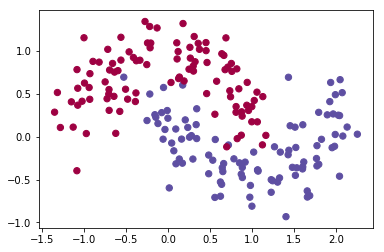

In [32]:
# Generate a dataset and plot it
import sklearn.datasets

np.random.seed(0)
x, y = sklearn.datasets.make_moons(200, noise = 0.20)
plt.scatter(x[:,0], x[:,1], s = 40, c = y, cmap = plt.cm.Spectral)

forward propagation

$$
\begin{aligned}
z_1 = xW_1 + b_1 \\
a_1 = \tanh(z_1) \\
z_2 = a_1W_2 + b_2 \\
a_2 = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

back propagation

$$
\begin{aligned}
\delta_3 = \hat{y} - y \\
\frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
\frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
\delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
\frac{\partial{L}}{\partial{b_2}} = \delta_3\\
\frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

cross-entropy loss

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

In [43]:
num_examples = len(x) # training data size
nn_input_dim = 2 # input layer dimension
nn_output_dim = 2 # output layer dimension 

# gradient descent parameters - picked randomly for now
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization


In [44]:
# evaluate total loss on the dataset

def calculate_loss(model):
    w1, b1, w2, b2 = model['w1'], model['b1'], model['w2'], model['b2']
    
    # forward propagation
    z1 = x.dot(w1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(w2) + b2
    # soft max for two dimensional output
    exp_scores = np.exp(z2)
    probs = exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)
    
    # cross-entropy loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # add regularization term to loss function
    data_loss += reg_lambda/2 * (np.sum(np.square(w1)) + np.sum(np.square(w2)))
    
    return 1/ num_examples * data_loss

In [49]:
# output prediction - output layer dimension is determined by the number of classes, each neuron standing for a class
def predict(model, x):
    w1, b1, w2, b2 = model['w1'], model['b1'], model['w2'], model['b2']
    
    # forward propagation
    z1 = x.dot(w1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(w2) + b2
    # soft max for two dimensional output
    exp_scores = np.exp(z2)
    probs = exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)
    
    return np.argmax(probs, axis = 1)


In [53]:
# nn_hdim: Number of neurons in the hidden layer
# num_passes: Number of passes through the training data for gradient descent
# print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes = 20000, print_loss = False):
    # parameter initialization
    np.random.seed(0)
    w1 = np.random.randn(nn_input_dim, nn_hdim)/ np.sqrt(nn_input_dim)
#     w1 = np.random.randn(nn_input_dim, nn_hdim)
    b1 = np.zeros((1, nn_hdim))
    w2 = np.random.rand(nn_hdim, nn_output_dim)/ np.sqrt(nn_hdim)
#     w2 = np.random.rand(nn_hdim, nn_output_dim)
    b2 = np.zeros((1, nn_output_dim))
    
    model = {}
    
    # batch gradient descent
    for i in range(0, num_passes):
        
        # forward propagation
        z1 = x.dot(w1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(w2) + b2
        # soft max for two dimensional output
        exp_scores = np.exp(z2)
        probs = exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)
    
        # backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dw2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis = 0, keepdims = True)
        delta2 = delta3.dot(w2.T) * (1 - np.power(a1, 2))
        dw1 = np.dot(x.T, delta2)
        db1 = np.sum(delta2, axis = 0)
        
        # add regularization terms
        dw2 += reg_lambda * w2
        dw1 += reg_lambda * w1
        
        # update gradient descent parameter
        w1 += - epsilon * dw1
        b1 += - epsilon * db1 
        w2 += - epsilon * dw2
        b2 += - epsilon * db2
        
        # assign updated parameters to the model
        model = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}
        
        # print the loss optionally 
        if print_loss and i % 1000 == 0:
            print('Loss after iteration %i: %f' %(i, calculate_loss(model)))
    
    return model

In [57]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    fig = plt.figure(figsize = (7, 5))
    plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral)
    plt.scatter(x[:, 0], x[:, 1], c = y, cmap = plt.cm.Spectral, alpha = 0.7)

Loss after iteration 0: 0.412746
Loss after iteration 1000: 0.069036
Loss after iteration 2000: 0.070785
Loss after iteration 3000: 0.070770
Loss after iteration 4000: 0.070772
Loss after iteration 5000: 0.070772
Loss after iteration 6000: 0.070771
Loss after iteration 7000: 0.070770
Loss after iteration 8000: 0.070768
Loss after iteration 9000: 0.070767
Loss after iteration 10000: 0.070766
Loss after iteration 11000: 0.070764
Loss after iteration 12000: 0.070763
Loss after iteration 13000: 0.070762
Loss after iteration 14000: 0.070762
Loss after iteration 15000: 0.070761
Loss after iteration 16000: 0.070760
Loss after iteration 17000: 0.070760
Loss after iteration 18000: 0.070760
Loss after iteration 19000: 0.070759


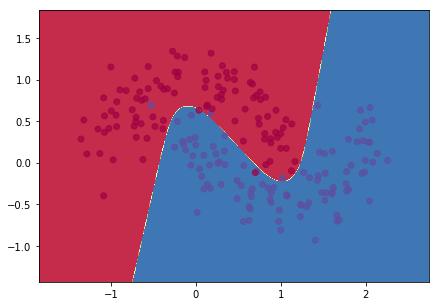

In [139]:
# use the network above to train 3 neuron a single hidden layer nn

model = build_model(3, print_loss = True)

plot_decision_boundary(lambda x: predict(model, x))